## Image Captioning V3

In [1]:
from picturedata.generator import DataGenerator
from keras.models import Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, merge, Activation, Flatten, GRU, Input
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Here the final model is created and trained. The model is based on https://github.com/anuragmishracse/caption_generator

In [2]:
generator = DataGenerator()

Total samples : 383454
Vocabulary size: 8256
Maximum caption length: 40
Image count: 30000


The structure of final model. Two networks, one for images and another for texts, merged into one to produce output. The text network uses RNN to process text, in this case, a LSTM.

In [3]:
embedding_dim = 128
image_input = Input(shape=(1000,))
image_model = Dense(embedding_dim, input_dim=1000, activation='relu')(image_input)

image_model = RepeatVector(generator.getMaxCapLen())(image_model)

language_input = Input(shape=(generator.getMaxCapLen(),))
language_model = Embedding(generator.getVocabSize(), 256, input_length=generator.getMaxCapLen())(language_input)
language_model = LSTM(256, return_sequences=True)(language_model)
#language_model.add(GRU(128, return_sequences=True))
language_model = TimeDistributed(Dense(embedding_dim))(language_model)

output = merge([image_model, language_model], mode='concat')
output = LSTM(1000, return_sequences=False)(output)
#model.add(GRU(256, return_sequences=False))
output = Dense(generator.getVocabSize())(output)
output = Activation('softmax')(output)

model = Model(inputs=[image_input, language_input], outputs=[output])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/ubuntu/.local/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [4]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 256)       2113536     input_2[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 128)           128128      input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
file_name = 'weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit_generator(generator.generate(batch_size=32), steps_per_epoch=generator.total_samples/32, epochs=20, verbose=1, callbacks=callbacks_list)
try:
    model.save('Models/WholeModel.h5', overwrite=True)
    model.save_weights('Models/Weights.h5',overwrite=True)
except:
    print "Error in saving model."

Generating data...Epoch 1/20

11982/11982 [==============================] - 2373s - loss: 4.5818 - acc: 0.3232  
Epoch 2/20
11982/11982 [==============================] - 2372s - loss: 4.8277 - acc: 0.3524  
Epoch 3/20
11982/11982 [==============================] - 2371s - loss: 4.6043 - acc: 0.3604  
Epoch 4/20
11982/11982 [==============================] - 2371s - loss: 4.6453 - acc: 0.3668  
Epoch 5/20
11982/11982 [==============================] - 2372s - loss: 4.6711 - acc: 0.3732  
Epoch 6/20
11982/11982 [==============================] - 2372s - loss: 4.7758 - acc: 0.3774  
Epoch 7/20
11982/11982 [==============================] - 2373s - loss: 4.7475 - acc: 0.3756  
Epoch 8/20
11982/11982 [==============================] - 2373s - loss: 4.7130 - acc: 0.3784  
Epoch 9/20
11982/11982 [==============================] - 2374s - loss: 4.7943 - acc: 0.3798  
Epoch 10/20
11982/11982 [==============================] - 2375s - loss: 4.7971 - acc: 0.3811  
Epoch 11/20
11982/11982 [=====

Best loss: 5.83936 acc: 0.2328

In [8]:
from pycocotools.coco import COCO
import numpy as np
import pandas as pd

In [9]:
annFile_val = "annotations/captions_val2014.json"

coco = COCO(annFile_val)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [9]:
imgIds = coco.getImgIds()
annIds = coco.getAnnIds(imgIds)

imgs = coco.loadImgs(imgIds)
anns = coco.loadAnns(annIds)

In [10]:
imgs_df = pd.DataFrame(imgs)
anns_df = pd.DataFrame(anns)

In [11]:
img_new = imgs_df.drop(['coco_url','date_captured','flickr_url','height','width','license'], axis=1)

img_new.rename(columns={'id': 'image_id'}, inplace=True)

anns_df['caption'] = anns_df['caption'].apply(lambda x: '<start>' + x + '<end>')

df = pd.merge(anns_df, img_new, on='image_id', how='left')

In [12]:
df.drop(['id'], axis=1, inplace=True)

In [13]:
img_files = set(df['file_name'])

In [14]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image, sequence
from imagenet_utils import preprocess_input

In [15]:
img_dir = "images/"
images = []
c = 0
for img_file in img_files:
    c += 1
    img = image.load_img(img_dir + img_file, target_size=(224, 224))
    images.append(img)
    if c == 100:
        break

In [16]:
model = VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))

c = 0
img_features = []
for img in images:
    c += 1
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.asarray(img)
    img_feature = model.predict(img)
    #img_feature = np.asarray(img_feature)
    #img_feature = img_feature.argmax(axis=-1)
    if c % 100 == 0:
        print "Processed {0} images".format(c)
        break
    img_features.append(img_feature[0])
img_features = np.asarray(img_features)

Processed 100 images


In [23]:
image = img_features[0]
start = [generator.word_index['<start>']]
captions = [[start, 0.0]]
while(len(captions[0][0]) < generator.max_cap_len):
    temp_captions = []
    for caption in captions:
        partial_caption = sequence.pad_sequences([caption[0]], maxlen=generator.max_cap_len, padding='post')
        next_words_pred = model.predict([np.asarray([image]), np.asarray(partial_caption)])[0]
        next_words = np.argsort(next_words_pred)[-3:]
        for word in next_words:
            new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
            new_partial_caption.append(word)
            new_partial_caption_prob+=next_words_pred[word]
            temp_captions.append([new_partial_caption,new_partial_caption_prob])
    
    captions = temp_captions
    captions.sort(key = lambda l:l[1])
    captions = captions[-3:]

    
captions.sort(key = lambda l:l[1])
best_caption = captions[-1][0]
caption = " ".join([generator.index_word[index] for index in best_caption])

caption_split = caption.split()
processed_caption = caption_split[1:]

try:
    end_index = processed_caption.index('<end>')
    processed_caption = processed_caption[:end_index]
except:
    pass
print " ".join([word for word in processed_caption])

A group of a a a from a from


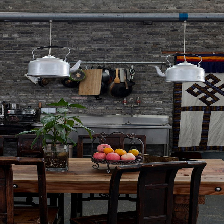

In [24]:
images[0]

In [25]:
generator.word_index

{u'fawn': 0,
 u'grimaces.': 1,
 u'wrought-iron': 2,
 u'snippets': 3,
 u'woods': 4,
 u'chars<end>': 5,
 u'hanging': 6,
 u'<start>person': 7,
 u'woody': 8,
 u'comically': 9,
 u'sunflowers,': 10,
 u'"Peace': 11,
 u'accessories,<end>': 12,
 u'dome.': 17972,
 u'<start>Nature': 14,
 u'canes': 15,
 u'rot.<end>': 16,
 u'canoe<end>': 14023,
 u'<start>Although': 18,
 u'caned': 19,
 u'Western': 20,
 u'crossbar': 21,
 u'snowboards.<end>': 22,
 u'<start>contemporary': 23,
 u'Euro': 24,
 u'unmade.': 25,
 u'play-mat': 23753,
 u'wood,': 26,
 u'wood.': 27,
 u'<start>Ironically,': 29,
 u'Enter",': 30,
 u'"Volt".<end>': 52545,
 u'cocker,spaniel': 31,
 u'bringing': 32,
 u'SIGNAL."<end>': 33,
 u'pepper.': 34,
 u'wooded': 36,
 u'chaos<end>': 37,
 u'broiler': 38,
 u'wooden': 39,
 u'<start>Authority': 40,
 u'<start>Past': 41,
 u'broiled': 42,
 u'wisk.<end>': 43,
 u'crotch': 44,
 u'Olympics': 45,
 u'sailboarder': 299,
 u'cane,': 47,
 u'seven.': 48,
 u'refridgerater': 49,
 u'sledboarding': 50,
 u'STATION"': 51,